<a href="https://colab.research.google.com/github/AhmadAkbariR/deepxde/blob/master/examples/operator/elasticity-2D-AAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @ 2D elastic square domain --> PINN-DeepONet

"""Backend supported: tensorflow, pytorch, paddle"""

import os
os.environ['DDE_BACKEND'] = 'pytorch'
try:
   import deepxde as dde
except ImportError:
   !pip install deepxde

#import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
current_backend = dde.backend.backend_name
print("Current default backend is:", current_backend)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Current default backend is: pytorch
Using device: cuda


Compiling model...
'compile' took 3.576215 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.13e+00, 4.47e-02, 0.00e+00, 8.77e-03, 9.48e-05, 1.57e-02, 1.44e-02]    [1.50e+00, 3.93e-02, 0.00e+00, 8.77e-03, 9.48e-05, 1.57e-02, 1.44e-02]    []  
1000      [2.97e-04, 6.87e-04, 0.00e+00, 3.46e-05, 5.85e-05, 3.25e-03, 2.12e-03]    [5.92e-04, 1.65e-03, 0.00e+00, 3.46e-05, 5.85e-05, 3.25e-03, 2.12e-03]    []  
2000      [2.62e-04, 4.00e-04, 0.00e+00, 1.94e-06, 2.26e-05, 2.31e-03, 1.65e-03]    [5.80e-04, 7.15e-04, 0.00e+00, 1.94e-06, 2.26e-05, 2.31e-03, 1.65e-03]    []  
3000      [2.45e-04, 2.90e-04, 0.00e+00, 4.33e-06, 2.14e-05, 1.96e-03, 1.46e-03]    [4.75e-04, 9.08e-04, 0.00e+00, 4.33e-06, 2.14e-05, 1.96e-03, 1.46e-03]    []  
3573      [1.93e-04, 2.99e-04, 0.00e+00, 5.15e-06, 2.17e-05, 1.88e-03, 1.34e-03]    [3.38e-04, 8.18e-04, 0.00e+00

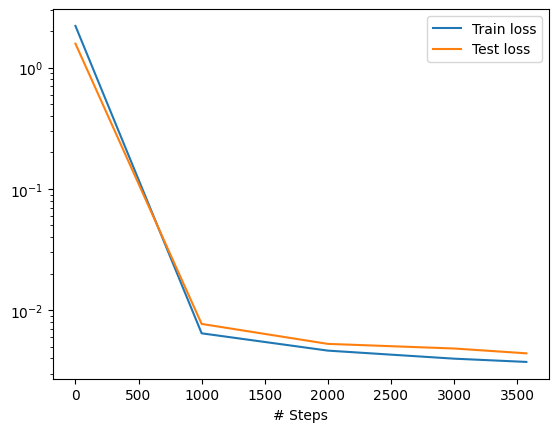

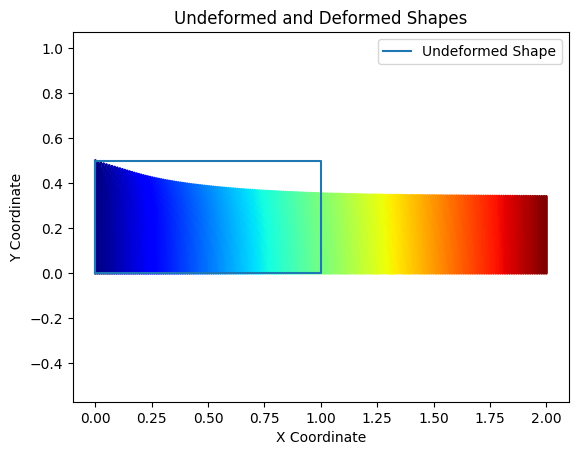

In [3]:
# @title PINN for 2D elasticity
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define the PDE system

nu = 0.3
E = 1

mu = E/(2*(1+nu))
landa2 = E*nu/((1+nu)*(1-nu))  # for 2D problems
landa3 = E*nu/((1+nu)*(1-2*nu))  # for 3D problems

def pde_system(x , u):
    # Define the parameters
    # Calculate the second derivatives of u and v
    u_xx = dde.grad.hessian(u, x, component=0, i = 0 , j = 0)
    u_yy = dde.grad.hessian(u, x, component=0, i = 1 , j = 1)
    u_xy = dde.grad.hessian(u, x, component=0, i = 0 , j = 1)
    u_yx = dde.grad.hessian(u, x, component=0, i = 1 , j = 0)
    u_xy = (u_xy + u_yx)/2
   # u_xy = dde.grad.hessian(u, [x, y])

   # v_xx = dde.grad.hessian(v, x)
   # v_yy = dde.grad.hessian(v, y)
   # v_xy = dde.grad.hessian(v, [x, y])
    v_xx = dde.grad.hessian(u, x, component=1, i = 0 , j = 0)
    v_yy = dde.grad.hessian(u, x, component=1, i = 1 , j = 1)
    v_xy = dde.grad.hessian(u, x, component=1, i = 0 , j = 1)
    v_yx = dde.grad.hessian(u, x, component=1, i = 1 , j = 0)
    v_xy = (v_xy + v_yx)/2
    # Define the equations
    #eq1 = u_xx + u_yy + (1 / (1 - 2 * nu)) * (u_xx + v_xy)
    #eq2 = v_xx + v_yy + (1 / (1 - 2 * nu)) * (v_yy + u_xy)
    # plane stress Navier equation
    eq1 = mu * (u_xx + u_yy) +  (landa2 + mu) * (u_xx + v_xy)
    eq2 = mu * (v_xx + v_yy) +  (landa2 + mu) * (v_yy + u_xy)

    return [ (eq1) , (eq2)]

# Define the geometry
lx = 1
ly = 0.5

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[lx, ly])

# Define the boundary condition functions
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], lx)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], ly)

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def First_grad(x, u):
    u_grad_x = dde.grad.jacobian(u, x, i=0, j=0)  # ∂u/∂x
    v_grad_y = dde.grad.jacobian(u, x, i=1, j=1)  # ∂v/∂y
    u_grad_y = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂x
    v_grad_x = dde.grad.jacobian(u, x, i=1, j=0)  # ∂u/∂x
    return u_grad_x, v_grad_y, u_grad_y, v_grad_x


def left_constraint(x , u, X=[]):
    # Compute the gradients
    u_grad_y = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂x
    v_grad_x = dde.grad.jacobian(u, x, i=1, j=0)  # ∂u/∂x
    # The Neumann condition: 2*nu*∂u/∂x + ∂v/∂y = 0
    return mu * (u_grad_y + v_grad_x)

def Right_constraint(x , u, X=[]):
    # Compute the gradients
    u_grad_y = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂x
    v_grad_x = dde.grad.jacobian(u, x, i=1, j=0)  # ∂u/∂x
    # The Neumann condition: 2*nu*∂u/∂x + ∂v/∂y = 0
    return mu * (u_grad_y + v_grad_x)

def Bottom_constraint(x , u, X=[]):
    # due to symmetry Sxy = 0, so u_y + v_x = 0
    u_grad_y = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂x
    v_grad_x = dde.grad.jacobian(u, x, i=1, j=0)  # ∂u/∂x
    return  mu * (u_grad_y + v_grad_x)

def top_contraint1(x , u, X=[]):
    # Compute the gradients
    u_grad_y = dde.grad.jacobian(u, x, i=0, j=1)  # ∂u/∂x
    v_grad_x = dde.grad.jacobian(u, x, i=1, j=0)  # ∂u/∂x
    # The Neumann condition: 2*nu*∂u/∂x + ∂v/∂y = 0
    return (u_grad_y + v_grad_x) * mu

def top_contraint2(x , u, X=[]):
    # Compute the gradients
    u_grad_x = dde.grad.jacobian(u, x, i=0, j=0)  # ∂u/∂x
    v_grad_y = dde.grad.jacobian(u, x, i=1, j=1)  # ∂v/∂y
    # The Neumann condition: 2*nu*∂u/∂x + ∂v/∂y = 0
    return  (2*mu + landa2)*v_grad_y + landa2 * u_grad_x
    #return v_grad_y + nu * u_grad_x

# Define the boundary conditions using DirichletBC
#bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left, component=0)    # u(x=0, y) = 0
#bc2 = dde.DirichletBC(geom, lambda x: 0, boundary_left, component=1)    # v(x=0, y) = 0
bc_right = dde.DirichletBC(geom, lambda x: 1, boundary_right, component=0)  # u(x=1, y) = 1
bc_left_cstrit = dde. OperatorBC(geom, left_constraint, boundary_left)  # u(x=1, y) = 1
bc_right_cstrit = dde. OperatorBC(geom, Right_constraint, boundary_right)  # u(x=1, y) = 1
bc_bottom_cstrit = dde. OperatorBC(geom, Bottom_constraint, boundary_bottom)  # u(x=1, y) = 1
bc_top_cstrit1 = dde. OperatorBC(geom, top_contraint1, boundary_top)  #
bc_top_cstrit2 = dde. OperatorBC(geom, top_contraint2, boundary_top)  #
#bc4 = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)  # v(x, y=0) = 0
#bc5 = dde.NeumannBC(geom, lambda x: 0, boundary_bottom, component=1)  #
#bc6 = dde.NeumannBC(geom, lambda x: 0, boundary_top, component=0)  #
#bc7 = dde.NeumannBC(geom, lambda x: 0, boundary_top, component=1)  #
# Define the Neumann boundary condition


# If you want both u and v to be zero at the boundary x = 0
# You can have something like:
# bc4 = dde.DirichletBC(geom, lambda x: 0, boundary_v_1)  # v(x=0, y) = 0
# Create a data object for the PDE
data = dde.data.PDE(geom,
                    pde_system,
                    [bc_right, bc_right_cstrit, bc_bottom_cstrit, bc_top_cstrit1, bc_top_cstrit2],
                    num_domain=1000,
                    num_boundary=3000, num_test=300)


#net = dde.nn.PFNN([2,[200, 200], [200, 200], [200, 200], [200, 200], 2], "relu", "Glorot uniform")
#net = dde.nn.FNN([2,5,5,5,  2], "tanh", "Glorot uniform")
net = dde.nn.FNN([2,20,20,20,20,20, 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2,[20, 20], [20, 20],  2], "tanh", "Glorot uniform")
def out_transform(inputs, outputs):

    x, y = inputs[:, 0], inputs[:, 1]
    # horizontal displacement on left
    u = outputs[:, 0] * x * (1-x) + x # torch.exp(x/(1+y))
    # vertical dis on left
    v = outputs[ :, 1] * y * x #torch.exp((x*y))
    ## pressure on bottom
    #p = outputs[:, :, 2] * y[None, :]
    return dde.backend.stack((u, v), axis=1)

net.apply_output_transform(out_transform)

model = dde.Model(data, net)
# Compile the model with an optimizer (instead of learning_rate here)

#model.compile("L-BFGS")

# model.compile("L-BFGS")
#losshistory, train_state = model.train(iterations=1000)
'''
model.compile("adam", lr=0.0005)  # Note changing learning_rate to lr
losshistory, train_state = model.train(iterations=2000)

model.compile("adam", lr=0.0003)  # Note changing learning_rate to lr
losshistory, train_state = model.train(iterations=2000)
'''
#model.compile("L-BFGS", loss="mse",
 #             loss_rtol=1e-5,      # Relative tolerance for loss
  #            tol=1e-5,            # Tolerance in the norm of the gradient
   #           max_iter=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train(iterations=1000)


dde.utils.plot_loss_history(losshistory)
plt.show()


#--------------------------------------------------------------------------#
###                          PREDICTION
#--------------------------------------------------------------------------#

X_test = geom.uniform_points(201*101 , True)

# Define the FirstDerivate callback
dudx_callback = dde.callbacks.FirstDerivative(X_test, component_x=0, component_y=0)
dudy_callback = dde.callbacks.FirstDerivative(X_test, component_x=0, component_y=1)
dvdx_callback = dde.callbacks.FirstDerivative(X_test, component_x=1, component_y=0)
dvdy_callback = dde.callbacks.FirstDerivative(X_test, component_x=1, component_y=1)

# Get the predictions
predictions = model.predict(X_test, callbacks=[dudx_callback, dudy_callback, dvdx_callback, dvdy_callback])

# After training, you can access the computed derivative values:
dudx = dudx_callback.get_value()  # Access the derivative values stored in the callback
dudy = dudy_callback.get_value()  # Access the derivative values stored in the callback
dvdx = dvdx_callback.get_value()  # Access the derivative values stored in the callback
dvdy = dvdy_callback.get_value()  # Access the derivative values stored in the callback


# Calculate strains
epsilon_x = dudx
epsilon_y = dvdy
epsilon_xy = 0.5 * (dudy + dvdx)

# Calculate stresses
sigma_x = 2*mu*epsilon_x +  landa2 * (epsilon_x + epsilon_y)
sigma_y = 2*mu*epsilon_y +  landa2 * (epsilon_x + epsilon_y)
sigma_xy = 2 * mu * epsilon_xy

#--------------------------------------------------------------------------#
###                          PLOT DEFORMATION
#--------------------------------------------------------------------------#

from scipy.spatial import ConvexHull

def deform_coord(X_test, predictions):
    return X_test + predictions

# Function to plot the boundary
def plot_boundary(X, label):
    if len(X) >= 3:  # A minimum of 3 points is needed to form a boundary
        hull = ConvexHull(X)
        # Add the first point to the end to close the polygon
        plt.plot(np.append(X[hull.vertices, 0], X[hull.vertices[0], 0]),
                 np.append(X[hull.vertices, 1], X[hull.vertices[0], 1]),
                 label=label)
    else:
        print("Not enough points to form a boundary.")
# Deformed coordinates
deformed = deform_coord(X_test, predictions)

# Calculate displacements in the x direction
u = predictions[:, 0]
v = predictions[:, 1]

# Plot undeformed shape boundary
plt.figure()
plot_boundary(X_test, 'Undeformed Shape')

# Plotting
plt.scatter(deformed[:,0],deformed[:,1],s = 1, c=u, cmap='jet', vmin=0, vmax=1)
plt.title('Undeformed and Deformed Shapes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()

plt.axis('equal')  # To maintain aspect ratio
plt.show()



In [4]:
argmax = X_test.argmax()
argmin = X_test.argmin()
print(sigma_x.max())
print(sigma_x.min())

1.5593966
0.93898016


In [5]:
print('landa: ',landa2)
print('landa: ',landa3)
print('mu: ',mu)
print('nu: ',nu)



landa:  0.32967032967032966
landa:  0.5769230769230769
mu:  0.3846153846153846
nu:  0.3


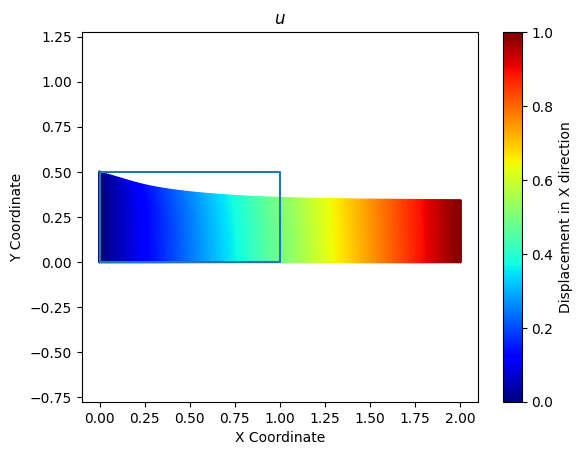

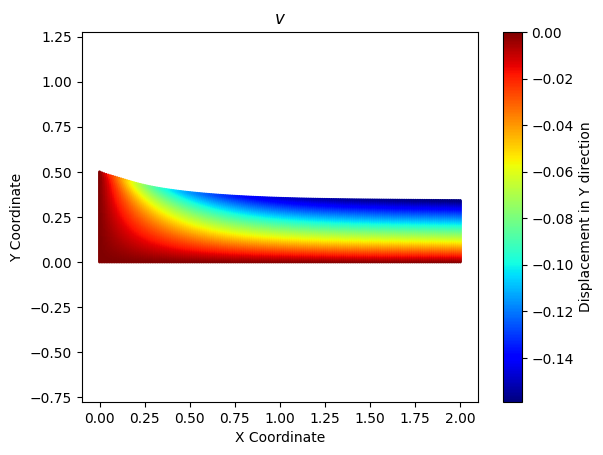

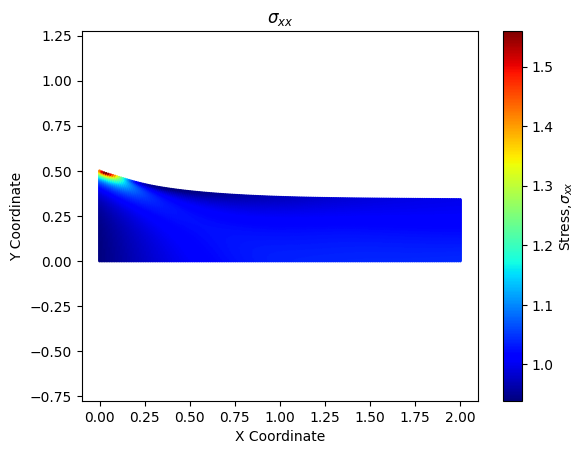

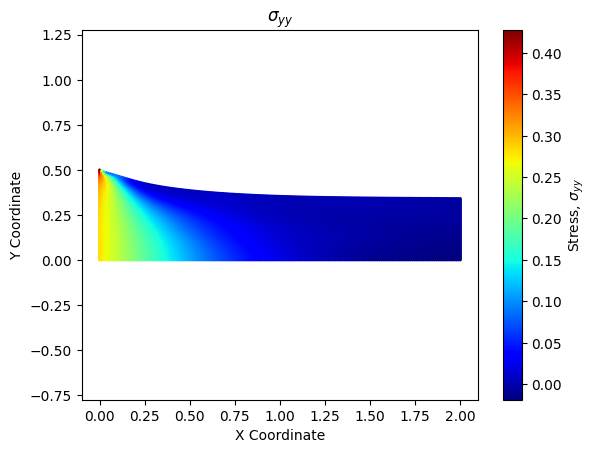

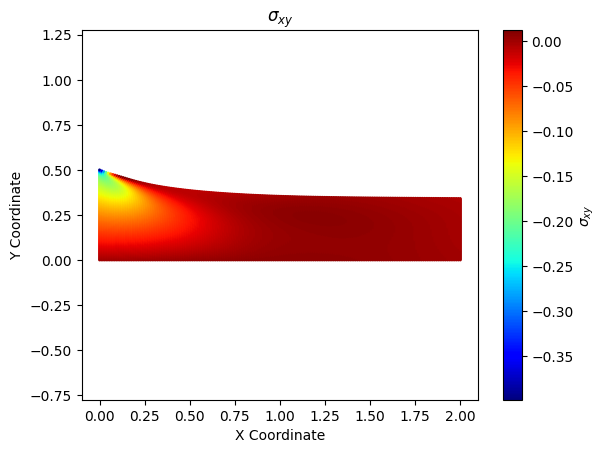

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test contains original coordinates and predictions contains the predicted coordinates after deformation
# Get the predictions
#predictions = model.predict(X_test)

# Deformed coordinates
deformed = deform_coord(X_test, predictions)

# Calculate displacements in the x direction
u = predictions[:, 0]
v = predictions[:, 1]

# Plot the deformed shape with color map for the displacement in x direction
plt.figure()

# Plot undeformed shape boundary

plot_boundary(X_test, 'Undeformed Shape')

scatter = plt.scatter(deformed[:, 0], deformed[:, 1], s = 1, c=u, cmap='jet', vmin=0, vmax=1)
plt.colorbar(scatter, label='Displacement in X direction')
plt.title(r'$u$')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.axis('equal')  # To maintain aspect ratio
plt.show()

# Plot the deformed shape with color map for the displacement in y direction
plt.figure()
scatter = plt.scatter(deformed[:, 0], deformed[:, 1], s = 1, c=v, cmap='jet', vmin=min(v), vmax=max(v))
plt.colorbar(scatter, label='Displacement in Y direction')
plt.title(r'$v$')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.axis('equal')  # To maintain aspect ratio
plt.show()

# Plot the deformed shape with color map for the s_xx
plt.figure()
scatter = plt.scatter(deformed[:, 0], deformed[:, 1], s = 1, c=sigma_x, cmap='jet', vmin=sigma_x.min(), vmax=sigma_x.max())
plt.colorbar(scatter, label='Stress,'r'$\sigma_{xx}$')
plt.title(r'$\sigma_{xx}$')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.axis('equal')  # To maintain aspect ratio
plt.show()


# Plot the deformed shape with color map for the s_yy
plt.figure()
scatter = plt.scatter(deformed[:, 0], deformed[:, 1], s = 1, c=sigma_y, cmap='jet', vmin=min(sigma_y), vmax=max(sigma_y))
plt.colorbar(scatter, label='Stress, 'r'$\sigma_{yy}$')
plt.title(r'$\sigma_{yy}$')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.axis('equal')  # To maintain aspect ratio
plt.show()

# Plot the deformed shape with color map for the s_xy
plt.figure()
scatter = plt.scatter(deformed[:, 0], deformed[:, 1], s = 1, c=sigma_xy, cmap='jet', vmin=min(sigma_xy), vmax=max(sigma_xy))
plt.colorbar(scatter, label= r'$\sigma_{xy}$')
plt.title(r'$\sigma_{xy}$')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.axis('equal')  # To maintain aspect ratio
plt.show()